In [65]:
import pandas as pd
from googleapiclient.discovery import build
from config import YOUTUBE_API_KEY

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
api_service_name = "youtube"
api_version = "v3"



youtube = build(api_service_name, api_version, developerKey=YOUTUBE_API_KEY)

In [18]:
channel_ids = [
    "UCsooa4yRKGN_zEE8iknghZA",

]


In [19]:
def collect_channel_stats(youtube, channel_ids):

    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )

    response = request.execute()

    # loop through items in response
    for item in response["items"]:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    
    return pd.DataFrame(all_data)



    

In [20]:
channel_info= collect_channel_stats(youtube, channel_ids)
channel_info

,channelName,subscribers,views,totalVideos,playlistId
0,TED-Ed,19400000,3808245431,2118,UUsooa4yRKGN_zEE8iknghZA


In [21]:
playlist_id = channel_info.loc[channel_info['channelName']== "TED-Ed", "playlistId"].iloc[0]
playlist_id

'UUsooa4yRKGN_zEE8iknghZA'

In [22]:
def collect_video_ids(youtube, playlist_id):
   

    video_ids = []

    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=100
        )
    response = request.execute()

    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                playlistId=playlist_id,
                maxResults=50,
                pageToken=next_page_token
            )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')    

        
    return video_ids


In [23]:
video_ids=collect_video_ids(youtube, playlist_id)
len(video_ids)

2118

In [24]:
def collect_video_details(youtube, video_ids):
    
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [25]:
video_df = collect_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Xu-QfE_1ksk,TED-Ed,The science of laughter - Sasha Winkler,Explore the common scientific theories about w...,"[laugh, laughter, humor, vocalization, reflex,...",2023-12-21T16:01:32Z,288857,12834,None,355,PT5M32S,hd,true
1,bbxmH_Kj7fk,TED-Ed,Does planting trees actually cool the planet? ...,Dig into common mistakes that tree-planting pr...,"[trees, tree planting, afforestation, reforest...",2023-12-19T16:00:24Z,213566,9557,None,325,PT5M41S,hd,true
2,00Ar2_irvJk,TED-Ed,What the biggest brain on Earth can do - David...,Explore how sperm whales use an array of compl...,"[sperm whales, whales, sperm whale, whale comm...",2023-12-14T16:00:35Z,179136,8109,None,180,PT5M36S,hd,true
3,tm6VSkm_ko8,TED-Ed,The largest river on Earth is actually in the ...,"Explore the Amazon rainforest’s flying rivers,...","[flying rivers, amazon flying rivers, amazon, ...",2023-12-12T16:00:45Z,552148,15559,None,294,PT5M37S,hd,true
4,sTW3dvuDmBE,TED-Ed,The rights you might not realize you have - Sh...,Do you have a right to a healthy planet? Dig i...,"[human rights, udhr, universal declaration of ...",2023-12-07T16:01:16Z,397122,7195,None,372,PT5M30S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,UG8YbNbdaco,TED-Ed,How pandemics spread,Dig into the history of pandemics to learn how...,"[Pandemics, pandemic, Flu, Virus, Health, Outb...",2012-03-12T04:15:15Z,3331064,40575,None,3809,PT8M,hd,true
2114,a1bWKZFP2Tc,TED-Ed,How many universes are there? - Chris Anderson,View the full lesson: http://ed.ted.com/lesson...,"[Philosophy and Religion, Chris Anderson, Univ...",2012-03-12T04:15:15Z,1903619,25111,None,2860,PT4M43S,hd,true
2115,ckGB5lHyzME,TED-Ed,Evolution in a Big City,"Using newts, coyotes and mice, Jason Munshi-So...","[Science and Technology, Evolution, City, Jaso...",2012-03-12T04:15:15Z,171300,1818,None,106,PT5M16S,hd,true
2116,tr4gWi9Jf6k,TED-Ed,The Cockroach Beatbox,"By dissecting a cockroach ... yes, live on sta...","[Science and Technology, Life Science, Awesome...",2012-03-12T04:15:15Z,897898,7591,None,640,PT6M16S,hd,true


In [46]:
top_20 = video_df.nlargest(20, 'viewCount')


C:\Users\yldrm\AppData\Local\Temp\ipykernel_3216\4169684666.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


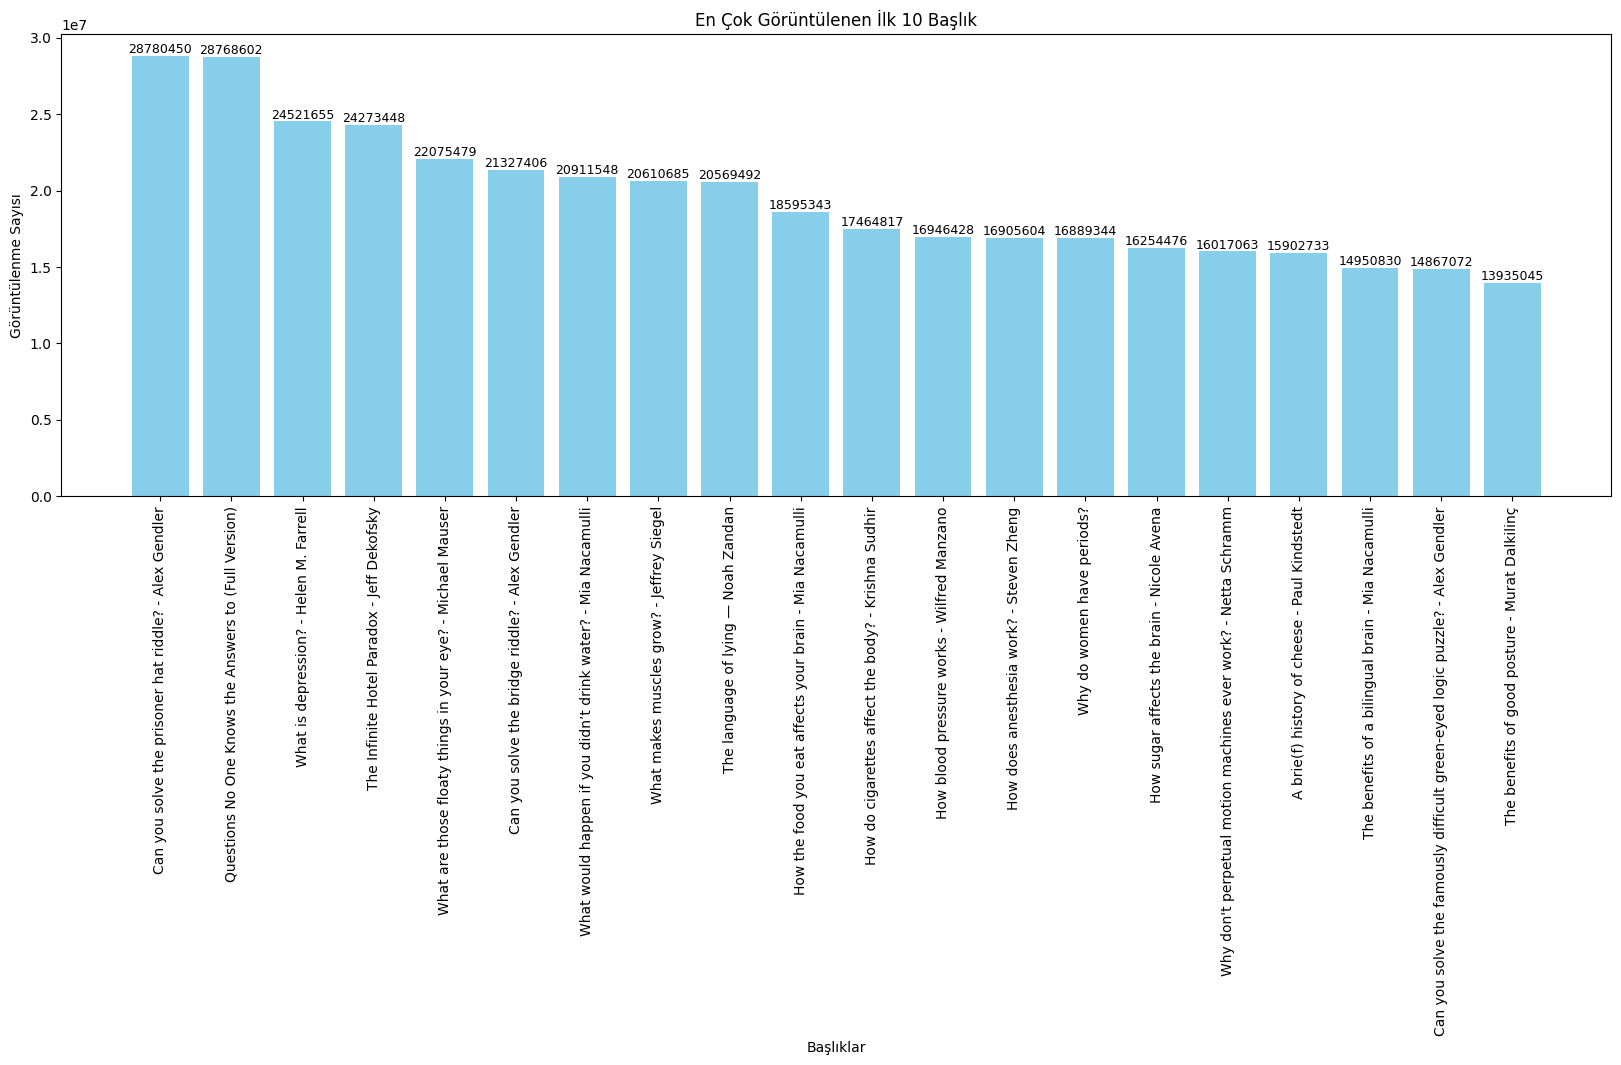

In [84]:
plt.figure(figsize=(20, 6))
bars = plt.bar(range(len(top_20['title'])), top_20['viewCount'], color='skyblue')

plt.xlabel('Başlıklar')
plt.ylabel('Görüntülenme Sayısı')
plt.title('En Çok Görüntülenen İlk 10 Başlık')

plt.xticks(range(len(top_20['title'])), top_20['title'], rotation=90)

for bar, value in zip(bars, top_20['viewCount']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), value,
             ha='center', va='bottom', color='black', fontsize=9)

plt.tight_layout()
plt.show()


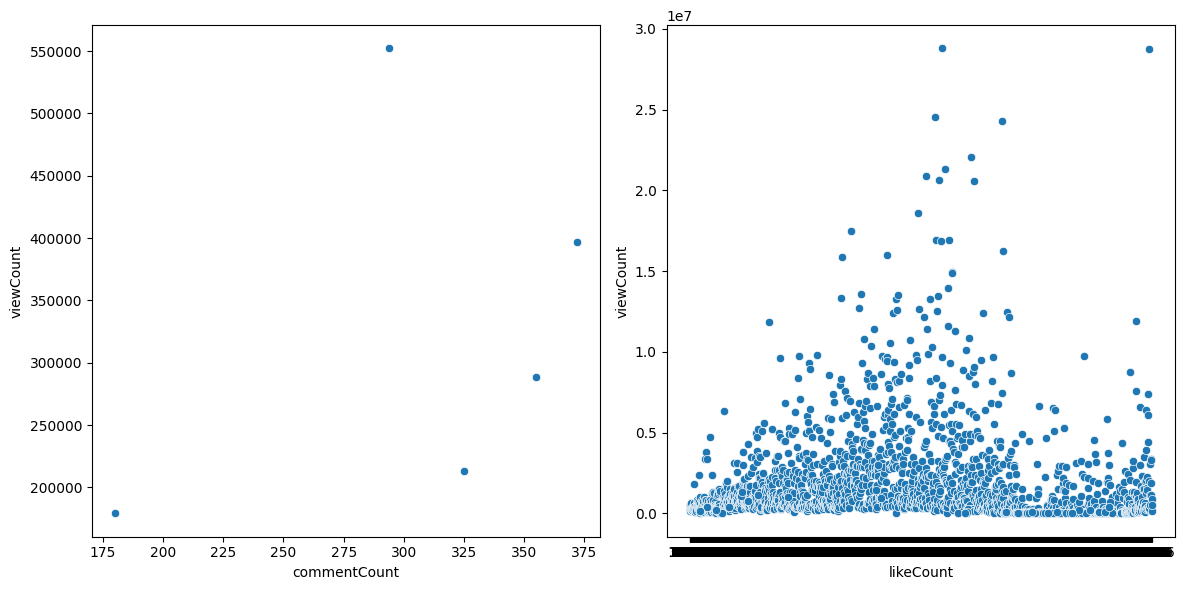

In [83]:
fig, ax = plt.subplots(1,2,figsize=(12, 6))
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])
plt.tight_layout()
plt.show()


In [85]:
video_df['commentCount'] = video_df['commentCount'].head(5).astype(int)
top_5 = video_df.nlargest(5, 'commentCount')
top_5

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
4,sTW3dvuDmBE,TED-Ed,The rights you might not realize you have - Sh...,Do you have a right to a healthy planet? Dig i...,"[human rights, udhr, universal declaration of ...",2023-12-07T16:01:16Z,397122,7195,None,372.0,PT5M30S,hd,true
0,Xu-QfE_1ksk,TED-Ed,The science of laughter - Sasha Winkler,Explore the common scientific theories about w...,"[laugh, laughter, humor, vocalization, reflex,...",2023-12-21T16:01:32Z,288857,12834,None,355.0,PT5M32S,hd,true
1,bbxmH_Kj7fk,TED-Ed,Does planting trees actually cool the planet? ...,Dig into common mistakes that tree-planting pr...,"[trees, tree planting, afforestation, reforest...",2023-12-19T16:00:24Z,213566,9557,None,325.0,PT5M41S,hd,true
3,tm6VSkm_ko8,TED-Ed,The largest river on Earth is actually in the ...,"Explore the Amazon rainforest’s flying rivers,...","[flying rivers, amazon flying rivers, amazon, ...",2023-12-12T16:00:45Z,552148,15559,None,294.0,PT5M37S,hd,true
2,00Ar2_irvJk,TED-Ed,What the biggest brain on Earth can do - David...,Explore how sperm whales use an array of compl...,"[sperm whales, whales, sperm whale, whale comm...",2023-12-14T16:00:35Z,179136,8109,None,180.0,PT5M36S,hd,true


In [87]:
video_id = 'sTW3dvuDmBE'  
comments = youtube.commentThreads().list(
    part='snippet',
    videoId=video_id,
    maxResults=100  # İsteğe bağlı olarak istediğiniz yorum sayısı
).execute()

# Gelen yorumları işleme
for comment in comments['items']:
    print(comment['snippet']['topLevelComment']['snippet']['textDisplay'])

If it requires the labor of another person then it&#39;s not a right.<br><br>/<br>/<br><br>The planet is humanity&#39;s shared Life Support System. Pollution is a crime, destruction an atrocity.
Human rights is the biggest scam west has ever proposed just to use it to their favors and completely ignoring it if it doesn&#39;t benefit them and their corporations 👏🏼
Josss semangat sukses selalu
인권과 환경의 관계<br>정의 추구
Wow❤
unprecedente 前例のない<br>S sweep O   SがO に広がる<br>court法廷<br>plaintiff 原告<br>sue 訴訟<br>inaction 活動していない<br>indigenous 先住民族の<br>fall short on  (目標に)達しない<br>suit 訴訟<br>distructive 破壊的な<br>put A at risk Aを危険にさらす<br>have to do with  ～と関係がかる<br>outline 概説する<br>backdrop 背景<br>atrocity 残虐行為<br>barbaric 野蛮な<br>inherent 固有の<br>revoke 取り消す<br>trial 裁判<br>adequate 十分な<br>laid 敷く<br>woven into ～に織り込まれる<br>constitution 憲法<br>opt 選択する<br>uphold 支持する
Can you make a video on Artificial intelligence? Would be nice to know about a current affair
So, if someone can sue the government about failin

In [89]:
comments = youtube.commentThreads().list(
    part='snippet',
    videoId=video_id,
    publishedAfter='2023-12-20T23:59:59Z',  # Belirli bir tarihten sonra yayınlanan yorumlar
    publishedBefore='2023-12-29T23:59:59Z',  # Belirli bir tarihten önce yayınlanan yorumlar
    maxResults=100  # İsteğe bağlı olarak istediğiniz yorum sayısı
).execute()


TypeError: Got an unexpected keyword argument publishedAfter